This notebook follows from rotate_no_resize_inference and running the nn-Unet model. It is used to find the Dice and sDice metric results. This script is to calculate the DICE, sDICE, and the Hausdorff distance of two sets of labels. The sets of labels are called (a) original for the manual labels and (b) predicted for the predicted labels
Documentation of metrics can be found here: https://github.com/deepmind/surface-distance


In [1]:
#Necessary imports
import os
import shutil

from ast import Break
import os
import SimpleITK as sitk
import numpy as np

import re

from absl.testing import absltest
from absl.testing import parameterized
import surface_distance
from surface_distance import metrics

import pandas as pd
import matplotlib.pyplot as plt


Set all necessary paths

In [2]:
nnUnet_res= '/home/chloe/nnUNet_Results/Task603_SettingUp_Res' #Change to path where you store nnUnet results
predicted_labels = 'results/transformed_results/predicted_labels'
rot_dir = 'results/transformed_results/transformed_images'

# Define the path to where you store transformed data and where to store nnUnet data
transform_label_dir = 'results/transformed_results/transformed_labels'
stored_label_folder = 'results/transformed_results/stored_transformed_labels'


Copy the results to the current working directory

In [3]:
#Maybe add to only move image outputs

file_names = os.listdir(nnUnet_res)
rot_names = os.listdir(rot_dir)
    
for file_name in file_names:
    for rot in rot_names:
        stored_rot_path = os.path.join(predicted_labels,rot)
        print(stored_rot_path)
        if not os.path.exists(stored_rot_path):
            os.makedirs(stored_rot_path)
        if file_name.endswith(rot+".nii.gz"):
            shutil.copy(os.path.join(nnUnet_res, file_name), stored_rot_path)


/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_-110.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_-60.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_150.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_60.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_-130.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_-70.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_180.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_10.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_20.0
/home/chloe/research/code/inference_05/results/transformed_results/predicted_labels/0.0_0.0_-160.0
/home/chloe/research

Move transformed manual labels into folder for computing Dice and sDice metrics

In [4]:
# Code to move transformed data from subfolders to single folder
rot_list = os.listdir(transform_label_dir) 

for rot in rot_list:
    stored_rot_path = os.path.join(stored_label_folder,rot)
    if not os.path.exists(stored_rot_path):
        os.makedirs(stored_rot_path)
    rot_path = os.path.join(transform_label_dir, rot)
    patient_names = os.listdir(rot_path)
    for patient in patient_names:
        patient_path = os.path.join(rot_path, patient)
        image_names = os.listdir(patient_path)
        for image in image_names:
            image_path = os.path.join(patient_path, image)
            shutil.copy(image_path, stored_rot_path)

Give names for predicted labels and rotated manual labels

In [5]:
#Loop over all the rotations
original_label_path = stored_label_folder 
predicted_label_path = predicted_labels

Set initial values and functions

In [6]:
def generate_np_array_of_single_structure(np_matrix, number):
    single_struct_array = np.where(np_matrix != number, 0, np_matrix)
    return single_struct_array.astype('bool')    # sets all 0-entries to False, and all others to True

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

num_structures = 1 + 1
s_dice_tolerance = 2 #mm

In [7]:
import re


rot_list = sorted_alphanumeric(os.listdir(predicted_label_path) )
print(rot_list)
#for rot in rot_list:


rot_list = (os.listdir(predicted_label_path) ).sort()
print(rot_list)

['0.0_0.0_0.0', '0.0_0.0_10.0', '0.0_0.0_20.0', '0.0_0.0_30.0', '0.0_0.0_40.0', '0.0_0.0_50.0', '0.0_0.0_60.0', '0.0_0.0_70.0', '0.0_0.0_80.0', '0.0_0.0_90.0', '0.0_0.0_100.0', '0.0_0.0_110.0', '0.0_0.0_120.0', '0.0_0.0_130.0', '0.0_0.0_140.0', '0.0_0.0_150.0', '0.0_0.0_160.0', '0.0_0.0_170.0', '0.0_0.0_180.0', '0.0_0.0_-10.0', '0.0_0.0_-20.0', '0.0_0.0_-30.0', '0.0_0.0_-40.0', '0.0_0.0_-50.0', '0.0_0.0_-60.0', '0.0_0.0_-70.0', '0.0_0.0_-80.0', '0.0_0.0_-90.0', '0.0_0.0_-100.0', '0.0_0.0_-110.0', '0.0_0.0_-120.0', '0.0_0.0_-130.0', '0.0_0.0_-140.0', '0.0_0.0_-150.0', '0.0_0.0_-160.0', '0.0_0.0_-170.0', '0.0_0.0_-180.0']
None


Iterate over file paths to obtain the metric

In [8]:
dice_matrix = np.zeros(num_structures)
hd_matrix = np.zeros(num_structures)
avg_surface_d_matrix = np.zeros(num_structures)
surf_dice_matrix = np.zeros(num_structures)

num_patients = 0
all_numbers = []
for i in range(num_structures):
    all_numbers.append(i)
print("all_numbers: ", all_numbers)

rot_list =  sorted_alphanumeric(os.listdir(predicted_label_path))
first_file_list = sorted_alphanumeric(os.listdir(os.path.join(original_label_path, rot_list[0])))

dice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)
sdice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)

rot_count = -1

for rot in rot_list:
    rot_count = rot_count + 1
    rot_pred_path = os.path.join(predicted_label_path, rot)
    rot_orig_path = os.path.join(original_label_path, rot)
    file_count = -1
    for filename in sorted_alphanumeric(os.listdir(rot_pred_path)):
        print("Predicting", filename)
        file_count = file_count + 1
        num_patients += 1
        dice_arr = np.zeros(num_structures)
        hd_arr = np.zeros(num_structures)
        avg_surface_d_arr = np.zeros(num_structures)
        surf_dice_arr = np.zeros(num_structures)

        # extract the example name
        # first split the path by '/' and take the last result to get the file name
        # then exclude the last 7 characters to exclude the '.nii.gz'
        name = filename.split('/')[-1][:-7]


        ############ ORIGINAL ############

        # read the label file and save it as nifti with correct naming
        orig_name = name.replace("0000_","")
        orig_name = orig_name.replace("image","label")
        original_data_path = rot_orig_path + "/" +  orig_name + ".nii.gz"
        original_img = sitk.ReadImage(original_data_path)  # read the file (file is the path to the label file)
        original_arr = sitk.GetArrayFromImage(original_img)

        # count amount of pixels with different labels
        unique, counts = np.unique(original_arr, return_counts=True)

        ############ PREDICTIONS ############

        # do the same for the corresponding image file
        pred_data_path = rot_pred_path + "/" +  name + ".nii.gz"
        pred_img = sitk.ReadImage(pred_data_path)  # exchange the _labels with _predictions in the file name to get the path to the predictions and reads the predictions
        pred_arr = sitk.GetArrayFromImage(pred_img)                 

        # count amount of pixels with different labels
        unique2, counts2 = np.unique(pred_arr, return_counts=True)

    #for each structure
        for number in range(num_structures):

            # no evalutation for background
            if(number == 0): continue

            if(number in unique2):
                #print("Analyzing structure: ", number)
                original_structure = generate_np_array_of_single_structure(original_arr, number)
                predicted_structure = generate_np_array_of_single_structure(pred_arr, number)

                # 3rd agument spacing_mm: resp. 3-element list-like structure. Voxel spacing in x0, x1 and x2 directions.
                surf_dist = metrics.compute_surface_distances(original_structure, predicted_structure, [3, 1, 1])
                dice = metrics.compute_dice_coefficient(original_structure, predicted_structure)

                # 2nd argument: percent: a float value between 0 and 100
                hd = metrics.compute_robust_hausdorff(surf_dist, 99)
                avg_sd = metrics.compute_average_surface_distance(surf_dist)
                s_dice = metrics.compute_surface_dice_at_tolerance(surf_dist, s_dice_tolerance)

                dice_arr[number] = dice
                hd_arr[number] = hd
                surf_dice_arr[number] = s_dice

            else: 
                # check if a predicted structure is missing
                print("missing structure in prediction: ", number)


            #Fill in array for each file (each row = rotation, each column = patient )
            dice_array[rot_count,file_count] = dice_arr[1]
            sdice_array[rot_count,file_count] = surf_dice_arr[1]

            dice_matrix = np.vstack((dice_matrix, dice_arr))
            hd_matrix = np.vstack((hd_matrix, hd_arr))
            #avg_surface_d_matrix = np.vstack(avg_surface_d_matrix, avg_surface_d_arr)
            surf_dice_matrix = np.vstack((surf_dice_matrix, surf_dice_arr))         


#First 


all_numbers:  [0, 1]
Predicting HN_P002_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P003_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P005_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P007_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P008_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P009_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P010_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P011_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P014_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P016_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P002_pre_0000_rotated_image_0.0_0.0_10.0.nii.gz
Predicting HN_P003_pre_0000_rotated_image_0.0_0.0_10.0.nii.gz
Predicting HN_P005_pre_0000_rotated_image_0.0_0.0_10.0.nii.gz
Predicting HN_P007_pre_0000_rotated_image_0.0_0.0_10.0.nii.gz
Predicting HN_P008_pre_0000_rotated_image_0.0_0.0_10.0.nii.gz
Predicting HN_P009_pre_0000_rotated_image_0.0_0.0_10.0.nii.

In [9]:
short_rot_list = [s.replace('0.0_0.0_','') for s in rot_list]
short_rot_list = [eval(i) for i in short_rot_list]
print(short_rot_list)

short_file_list = [s.replace('_pre_rotated_label_0.0_0.0_0.0.nii.gz','') for s in first_file_list]
print(short_file_list)

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, -10.0, -20.0, -30.0, -40.0, -50.0, -60.0, -70.0, -80.0, -90.0, -100.0, -110.0, -120.0, -130.0, -140.0, -150.0, -160.0, -170.0, -180.0]
['HN_P002', 'HN_P003', 'HN_P005', 'HN_P007', 'HN_P008', 'HN_P009', 'HN_P010', 'HN_P011', 'HN_P014', 'HN_P016']


Visualize Full Dice and sDice arrays

In [10]:
print("Dice:")
dice_table = pd.DataFrame(dice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(dice_table)

print("sDice:")
sdice_table = pd.DataFrame(sdice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(sdice_table)

Dice:
         HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009   HN_P010  \
-180.0  0.625983  0.599293  0.000000  0.000000  0.000000  0.000000  0.000000   
-170.0  0.592107  0.471449  0.000000  0.000000  0.000000  0.000000  0.000000   
-160.0  0.584164  0.635041  0.000000  0.000000  0.000000  0.000000  0.000000   
-150.0  0.590348  0.605067  0.000000  0.000000  0.000000  0.000000  0.000000   
-140.0  0.591314  0.440200  0.000000  0.000000  0.000000  0.000000  0.000000   
-130.0  0.586131  0.602456  0.000000  0.000000  0.000000  0.000000  0.000000   
-120.0  0.593975  0.456241  0.000000  0.000000  0.000000  0.000000  0.000000   
-110.0  0.510538  0.468751  0.000000  0.000000  0.000000  0.000000  0.000000   
-100.0  0.447535  0.387835  0.000000  0.000000  0.000000  0.000000  0.000000   
-90.0   0.421734  0.419480  0.449097  0.152233  0.366584  0.461952  0.458895   
-80.0   0.479084  0.516250  0.492217  0.282875  0.404884  0.471050  0.464023   
-70.0   0.564015  0.493754  0.5473

In [11]:
df = dice_array[:,1]

Create plots for Dice and sDice

In [12]:
short_file_list[1]

'HN_P003'

Separate Experiment 1 and Experiment 2 arrays

In [37]:
#Ex 1 = (-90,90) every 10
dice_table_ex1 = dice_table.iloc[9:28,:]
sdice_table_ex1 = sdice_table.iloc[9:28,:]

print("Ex 1 Dice:")
print(dice_table_ex1)

print("Ex 1 sDice:")
print(sdice_table_ex1)

#Ex 2 = (-90,90) every 10
dice_table_ex2 = dice_table.iloc[:,0:2]
sdice_table_ex2 = sdice_table.iloc[:,0:2]

print("Ex 2 Dice:")
print(dice_table_ex2)

print("Ex 2 sDice:")
print(sdice_table_ex2)


Ex 1 Dice:
        HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009   HN_P010  \
-90.0  0.421734  0.419480  0.449097  0.152233  0.366584  0.461952  0.458895   
-80.0  0.479084  0.516250  0.492217  0.282875  0.404884  0.471050  0.464023   
-70.0  0.564015  0.493754  0.547327  0.410041  0.444295  0.478278  0.460804   
-60.0  0.579915  0.430538  0.570497  0.456661  0.531119  0.497791  0.478974   
-50.0  0.606849  0.550316  0.601752  0.588456  0.580990  0.510263  0.491856   
-40.0  0.638841  0.403675  0.593564  0.439693  0.600171  0.527008  0.515995   
-30.0  0.651000  0.547029  0.605963  0.601257  0.611526  0.543501  0.499531   
-20.0  0.661419  0.580298  0.605958  0.595228  0.617810  0.546251  0.502024   
-10.0  0.640686  0.434165  0.613921  0.578454  0.620639  0.547224  0.506070   
 0.0   0.625799  0.599224  0.596890  0.605639  0.627882  0.541724  0.518643   
 10.0  0.592010  0.470445  0.586995  0.613835  0.629107  0.543931  0.529031   
 20.0  0.584239  0.635403  0.587757  0.62

Experiment 1 Dice and sDice Plots

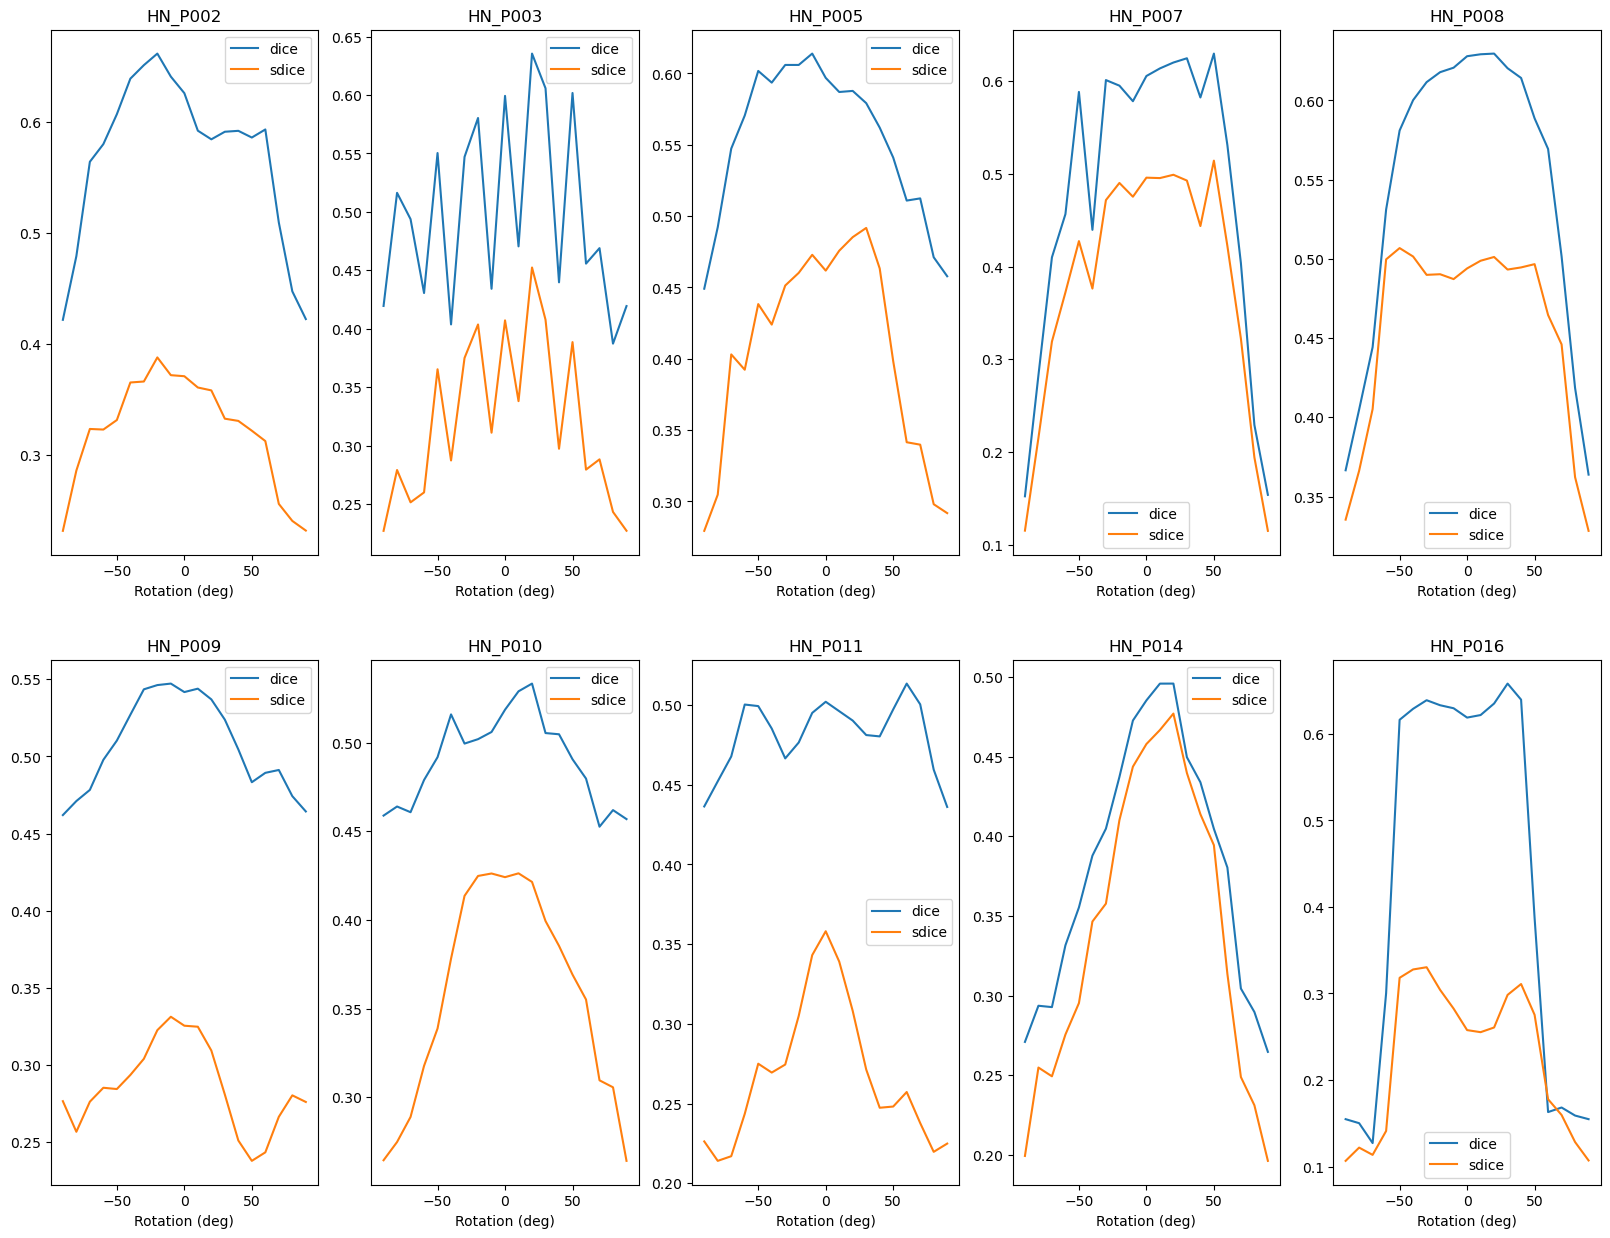

In [40]:
#Experiment 1 Dice and sDice plots
nrows=2
ncols=5
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(20,15)
index = 0
for i in range(nrows):
    for j in range(ncols):
        patient = short_file_list[index]
        df = pd.DataFrame().assign(dice=dice_table_ex1[patient],sdice = sdice_table_ex1[patient])
        df.plot(title = patient, ax=axes[i,j], xlabel = 'Rotation (deg)')
        index = index + 1

Experiment 2 Dice and sDice plots

0 0
0 1


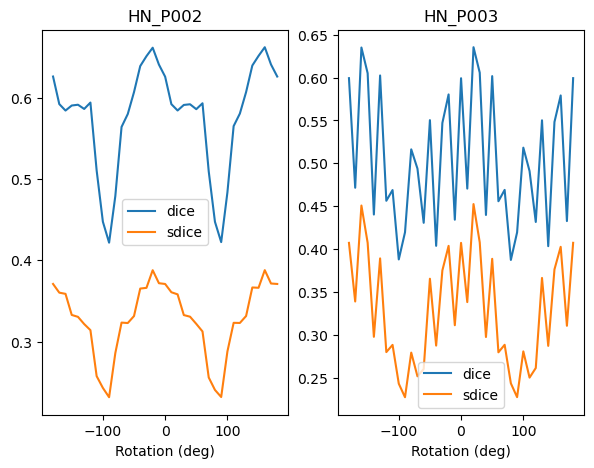

In [39]:
#Experiment 2 Dice and sDice plots
nrows=1
ncols=2
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(7,5)
index = 0
for i in range(nrows):
    for j in range(ncols):
        patient = short_file_list[index]
        df = pd.DataFrame().assign(dice=dice_table[patient],sdice = sdice_table[patient])
        print(i,j)
        df.plot(title = patient, ax=axes[j], xlabel = 'Rotation (deg)')
        index = index + 1


In [45]:
#Experiment 1 Errors in the table 


zero_index = np.floor(len(rot_list)/2)

err_dice_array = dice_array - dice_array[0,:]

err_sdice_array = sdice_array - sdice_array[0,:]

print("Dice Absolute Error:")
abs_err_dice_table = pd.DataFrame(err_dice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_dice_table)

print("sDice Absolute Error:")
abs_err_sdice_table = pd.DataFrame(err_sdice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_sdice_table)

Dice Absolute Error:
         HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009   HN_P010  \
-180.0  0.000184  0.000069  0.596890  0.605639  0.627882  0.541724  0.518643   
-170.0  0.033692  0.127775  0.596890  0.605639  0.627882  0.541724  0.518643   
-160.0  0.041635  0.035817  0.596890  0.605639  0.627882  0.541724  0.518643   
-150.0  0.035450  0.005844  0.596890  0.605639  0.627882  0.541724  0.518643   
-140.0  0.034485  0.159023  0.596890  0.605639  0.627882  0.541724  0.518643   
-130.0  0.039668  0.003232  0.596890  0.605639  0.627882  0.541724  0.518643   
-120.0  0.031824  0.142983  0.596890  0.605639  0.627882  0.541724  0.518643   
-110.0  0.115261  0.130473  0.596890  0.605639  0.627882  0.541724  0.518643   
-100.0  0.178264  0.211389  0.596890  0.605639  0.627882  0.541724  0.518643   
-90.0   0.204065  0.179744  0.147792  0.453406  0.261298  0.079772  0.059748   
-80.0   0.146714  0.082974  0.104673  0.322764  0.222998  0.070674  0.054620   
-70.0   0.061784  0

Seperate Experiment 1 and 2 Error Arrays

In [48]:
abs_err_dice_table_ex1 = abs_err_dice_table.iloc[9:28,:]
abs_err_sdice_table_ex1 = abs_err_sdice_table.iloc[9:28,:]

print("Ex 1 Dice:")
print(abs_err_dice_table_ex1)

print("Ex 1 sDice:")
print(abs_err_sdice_table_ex1)

#Ex 2 = (-90,90) every 10
abs_err_dice_table_ex2 = abs_err_dice_table.iloc[:,0:2]
abs_err_sdice_table_ex2 = abs_err_sdice_table.iloc[:,0:2]

print("Ex 1 Dice:")
print(abs_err_dice_table_ex2)

print("Ex 1 sDice:")
print(abs_err_sdice_table_ex2)

Ex 1 Dice:
        HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009   HN_P010  \
-90.0  0.204065  0.179744  0.147792  0.453406  0.261298  0.079772  0.059748   
-80.0  0.146714  0.082974  0.104673  0.322764  0.222998  0.070674  0.054620   
-70.0  0.061784  0.105470  0.049563  0.195598  0.183587  0.063446  0.057839   
-60.0  0.045884  0.168686  0.026392  0.148978  0.096763  0.043933  0.039669   
-50.0  0.018950  0.048908  0.004862  0.017183  0.046892  0.031460  0.026787   
-40.0  0.013042  0.195549  0.003326  0.165946  0.027711  0.014716  0.002648   
-30.0  0.025201  0.052194  0.009073  0.004382  0.016355  0.001778  0.019112   
-20.0  0.035621  0.018926  0.009069  0.010411  0.010072  0.004527  0.016619   
-10.0  0.014887  0.165058  0.017031  0.027185  0.007242  0.005500  0.012573   
 0.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10.0  0.033789  0.128778  0.009895  0.008196  0.001225  0.002207  0.010388   
 20.0  0.041560  0.036179  0.009132  0.01

Get MAE for Ex1

In [49]:
#Get mean absolute value table
print("Mean Absolute Dice Error:")
MAE_dice_table = abs_err_dice_table_ex1.mean(axis = 1)
print(MAE_dice_table)

print("Mean Absolute sDice Error:")
MAE_sdice_table = abs_err_sdice_table_ex1.mean(axis = 1)
print(MAE_sdice_table)


Mean Absolute Dice Error:
-90.0    0.213008
-80.0    0.171583
-70.0    0.143598
-60.0    0.104436
-50.0    0.033033
-40.0    0.054740
-30.0    0.026426
-20.0    0.019317
-10.0    0.027988
 0.0     0.000000
 10.0    0.021384
 20.0    0.016116
 30.0    0.021260
 40.0    0.041008
 50.0    0.056500
 60.0    0.105892
 70.0    0.140907
 80.0    0.192429
 90.0    0.212812
dtype: float64
Mean Absolute sDice Error:
-90.0    0.179134
-80.0    0.147962
-70.0    0.120606
-60.0    0.095439
-50.0    0.061874
-40.0    0.063860
-30.0    0.036413
-20.0    0.018229
-10.0    0.019726
 0.0     0.000000
 10.0    0.013153
 20.0    0.018274
 30.0    0.028754
 40.0    0.052562
 50.0    0.048597
 60.0    0.088583
 70.0    0.117862
 80.0    0.154963
 90.0    0.179072
dtype: float64


<Axes: title={'center': 'Mean Absolute Dice Error Across Patient Samples'}, xlabel='Rotation (deg)', ylabel='MAE'>

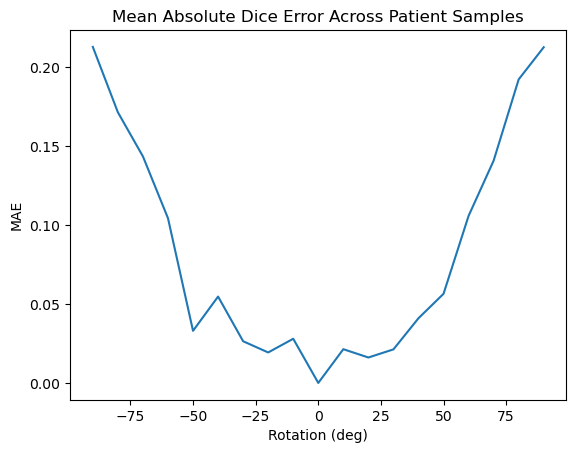

In [50]:
MAE_dice_table.plot(title = 'Mean Absolute Dice Error Across Patient Samples', xlabel = 'Rotation (deg)', ylabel = 'MAE')

<Axes: title={'center': 'Mean Absolute sDice Error Across Patient Samples'}, xlabel='Rotation (deg)', ylabel='MAE'>

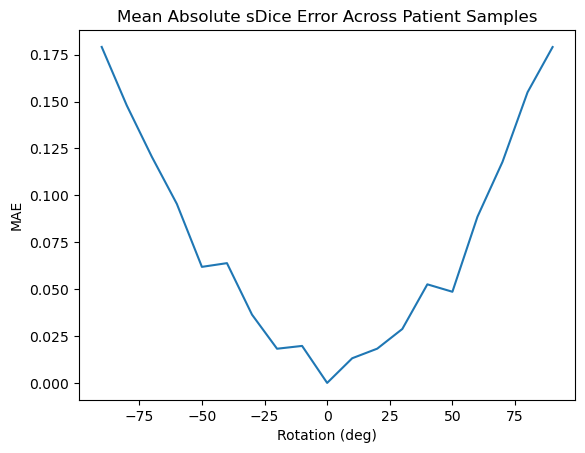

In [51]:
MAE_sdice_table.plot(title = 'Mean Absolute sDice Error Across Patient Samples', xlabel = 'Rotation (deg)', ylabel = 'MAE')

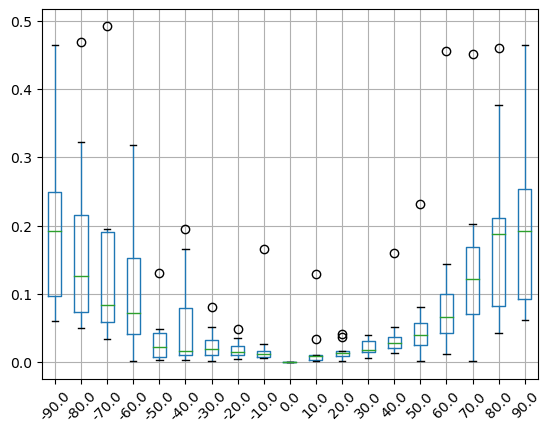

In [60]:
boxplot = abs_err_dice_table_ex1.T.boxplot(rot=45)  

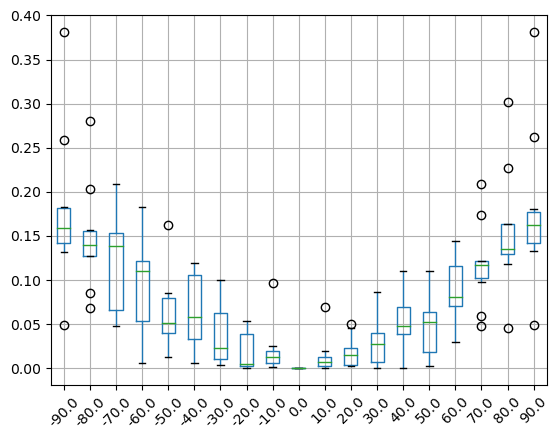

In [59]:
boxplot = abs_err_sdice_table_ex1.T.boxplot(rot=45)  

Get MAE for Ex 2

In [55]:
#Get mean absolute value table
print("Mean Absolute Dice Error:")
MAE_dice_table = abs_err_dice_table_ex2.mean(axis = 1)
print(MAE_dice_table)

print("Mean Absolute sDice Error:")
MAE_sdice_table = abs_err_sdice_table_ex2.mean(axis = 1)
print(MAE_sdice_table)

Mean Absolute Dice Error:
-180.0    0.000127
-170.0    0.080734
-160.0    0.038726
-150.0    0.020647
-140.0    0.096754
-130.0    0.021450
-120.0    0.087403
-110.0    0.122867
-100.0    0.194826
-90.0     0.191905
-80.0     0.114844
-70.0     0.083627
-60.0     0.107285
-50.0     0.033929
-40.0     0.104296
-30.0     0.038698
-20.0     0.027273
-10.0     0.089973
 0.0      0.000000
 10.0     0.081284
 20.0     0.038869
 30.0     0.020619
 40.0     0.096727
 50.0     0.021208
 60.0     0.088109
 70.0     0.123375
 80.0     0.195211
 90.0     0.191612
 100.0    0.111616
 110.0    0.084526
 120.0    0.106528
 130.0    0.034008
 140.0    0.104819
 150.0    0.038303
 160.0    0.028158
 170.0    0.090813
 180.0    0.000138
dtype: float64
Mean Absolute sDice Error:
-180.0    0.000015
-170.0    0.039526
-160.0    0.027856
-150.0    0.019086
-140.0    0.075010
-130.0    0.033695
-120.0    0.092099
-110.0    0.116150
-100.0    0.146031
-90.0     0.159650
-80.0     0.106474
-70.0     0.101583
-

<Axes: title={'center': 'Mean Absolute Dice Error Across Patient Samples'}, xlabel='Rotation (deg)', ylabel='MAE'>

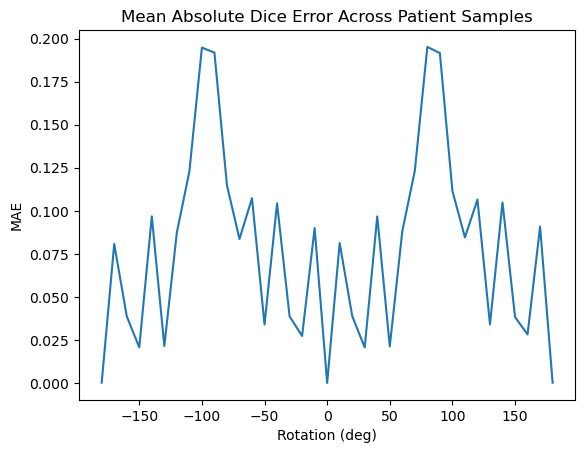

In [56]:
MAE_dice_table.plot(title = 'Mean Absolute Dice Error Across Patient Samples', xlabel = 'Rotation (deg)', ylabel = 'MAE')

<Axes: title={'center': 'Mean Absolute Dice Error Across Patient Samples'}, xlabel='Rotation (deg)', ylabel='MAE'>

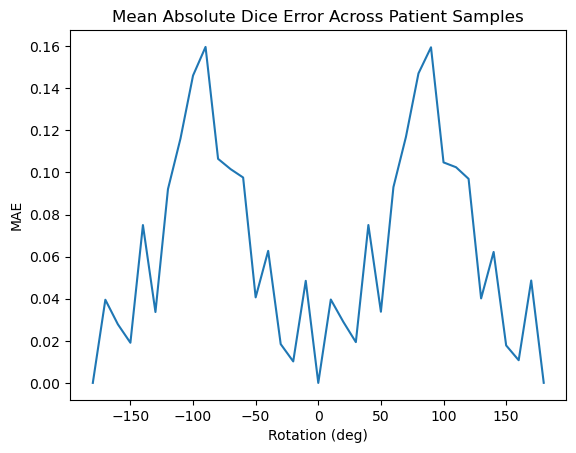

In [57]:
MAE_sdice_table.plot(title = 'Mean Absolute Dice Error Across Patient Samples', xlabel = 'Rotation (deg)', ylabel = 'MAE')